# Read the PDF

In [38]:
# libraries for text cleaning
%pip install nltk
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords as sw
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer

# library to read the PDF
%pip install pdfplumber
import pdfplumber

# convert date string to datetime format
from datetime import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/henrytran/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/henrytran/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/henrytran/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
# We should use this code
# this is the text extracted from the first 3 pages extracted from the
def raw_data_extraction(input_pdf):
    # take the pdf as an input and return the whole pdf as text
    raw_input=""
    with pdfplumber.open(input_pdf) as pdf:
        for page in pdf.pages:
            raw_input+=(page.extract_text() or "") + "\n"
    return raw_input

def article_extraction(raw_input):
    article=""
    details=""
    article_idx=0
    article_dict={}
    details_dict={}
    article_status=False # mark the start of the article
    details_status=False
    for row in raw_input.lower().split('\n'):
        if row=='full text':
            article_status=True
            article_idx+=1
            continue
        if article_status:
            if row=='details':
                article_status=False
                details_status=True
                article_dict[article_idx] = article
                article=""
                continue
            article+=row+" "
        if details_status:
            if row=='links':
                details_status=False
                details_dict[article_idx]=details
                details=""
                continue
            details+=row+'\n'
    return article_dict, details_dict

def clean_article(article):
    lemmatizer=WordNetLemmatizer()
    desc = re.sub(r'\([^)]*\)', '', article)
    sent_desc =sent_tokenize(desc)
    sww=set(sw.words())
    abstraction = []
    for sent in sent_desc:
        # normalise U.S., US, USA, U.S.A., etc. all to "america" (for classification)
        sent = re.sub(r"\b(?:u\.?\s*s\.?|usa|u\.?\s*s\.?\s*a\.?)\b", "america", sent, flags=re.IGNORECASE)
        # normalise to lowercase and only letters and numbers
        tokens = re.sub(r"[^a-z0-9]+", " ", sent.lower())
        words = word_tokenize(tokens)
        remaining_words = [word for word in words if word not in sww]
        if remaining_words:
            lemmatised_words=[]
            for word in remaining_words:
                lemmatised_word=lemmatizer.lemmatize(word)
                lemmatised_words.append(lemmatised_word)
            abstraction.append(lemmatised_words)
    final_doc=""
    for sent in abstraction[:-1]:
        for word in sent:
            final_doc+=word+" "
    return final_doc # remove the name of the writer

def clean_detail(detail):
    year=None
    date=None
    article_id=""
    for row in detail.split('\n'):
        if row.split(":")[0]=="proquest document id" or row.split(":")[0]=="proquestdocument id" or row.split(":")[0]=="proquestdocumentid" or row.split(":")[0]=="proquest documentid":
            article_id=row.split(":")[1].strip().split(" ")
            if len(article_id)>1:
                new_id=""
                for part in article_id:
                    new_id+=part
                article_id=[new_id]
            continue
        #if row.split(":")[0]=="publication year":
            #year = str(row.split(":")[1].strip())
            #print(year)
        if row.split(":")[0]=="publication date":
            raw_date=row.split(":")[1].split(",")[0].strip().split(" ")
            raw_year=row.split(":")[1].split(",")[1].strip().split(" ")
            raw_date1=""
            raw_date2=""
            for value in raw_date: # add date
                raw_date1+=value
            for value in raw_year: # add year
                raw_date1+=value
            if len(raw_date1)==8:
                raw_date2+=raw_date1[:3]+" "+raw_date1[3]+" "+raw_date1[4:]
            if len(raw_date1)==9:
                raw_date2+=raw_date1[:3]+" "+raw_date1[3:5]+" "+raw_date1[5:]
            #full_raw_date= raw_date2 + " "+ year
            format_date= "%b %d %Y"           
            date = datetime.strptime(raw_date2, format_date)
    return (date.date() if date else None), article_id
    



# To find the unique words and count for the 222 articles

1-3 grams

In [3]:
raw_input222 = raw_data_extraction('ProQuestDocuments-2025-08-16_1_fiscalpolicy_last12.pdf')
article222_dict, details222_dict = article_extraction(raw_input222)

#for key in article222_dict.keys():
 #   cleaned_article222 = clean_article(article222_dict[key])
 #   print(cleaned_article222)

In [4]:
from nltk.util import ngrams
from collections import Counter

# cleaned tokens 
all_tokens = []
for key, article in article222_dict.items():
    cleaned_article = clean_article(article)   
    tokens = cleaned_article.split()
    all_tokens.extend(tokens)

# remove token that are only numbers
def is_word(token):
    # keep only tokens with letters (ignore pure numbers)
    return re.match(r'^[A-Za-z]+$', token)

filtered_tokens = [tok for tok in all_tokens if is_word(tok)]

# 1/2/3 grams
ngram_counts = Counter()
for n in [1, 2, 3]:
    ngrams_list = [" ".join(ng) for ng in ngrams(filtered_tokens, n)]
    ngram_counts.update(ngrams_list)

# top n phrases (500)
top_phrases = ngram_counts.most_common(500)

# results
print("Number of unique phrases (1–3 grams):", len(ngram_counts))
print("Top 500 phrases:\n")
for phrase, count in top_phrases:
    print(f"{phrase}: {count}")

 
# Convert the list of tuples into a df
top_phrases_df = pd.DataFrame(top_phrases, columns=["phrase", "count"])

# esxport to csv
top_phrases_df.to_csv("top_phrases.csv", index=False)

Number of unique phrases (1–3 grams): 172898
Top 500 phrases:

tax: 1199
trump: 1099
america: 941
year: 918
cut: 698
republican: 556
house: 503
president: 480
tariff: 454
spending: 451
bill: 434
policy: 415
government: 414
budget: 371
china: 356
rate: 352
company: 352
fiscal: 337
tax cut: 335
economic: 321
federal: 317
economy: 310
state: 309
billion: 298
deficit: 287
market: 284
plan: 280
price: 279
growth: 273
increase: 268
administration: 264
million: 261
senate: 259
trillion: 251
country: 235
cost: 233
trade: 233
month: 229
higher: 227
debt: 223
time: 218
inflation: 218
make: 216
term: 209
investor: 204
program: 201
bank: 201
official: 196
day: 196
change: 195
week: 194
income: 193
dollar: 193
security: 193
money: 189
economist: 184
including: 184
democrat: 180
business: 177
vote: 176
american: 175
congress: 169
interest: 168
party: 168
treasury: 164
work: 163
recent: 162
back: 162
high: 160
pay: 160
biden: 159
investment: 157
white: 154
medicaid: 154
office: 152
law: 152
committee

# Create the set of fiscal policy related words

In [6]:
terms_categories = {
    # Core fiscal categories
    'tax': ['tax cuts','tax increases','tax rates','taxes','tax legislation','income taxes'],
    
    'budget_debt': ['budget deficits','federal budget','deficit financing','national debt',
                    'borrowing','federal funding','government debt'],
    
    'spending_social_programs': ['defense spending','social security','medicare','stimulus',
                                'federal spending'],

    'fiscal_policy': ['fiscal policy','fiscal stimulus','fiscal reform'],

    'tariffs_trade': ['tariffs','trade policy','trade disputes','international trade',
                    'trade relations','exports','supply chains','border security',
                    'immigration policy','immigration','deportation',],

    # America filter
    'america': ['america','american',
        "alabama","alaska","arizona","arkansas","california","colorado",
        "connecticut","delaware","florida","georgia","hawaii","idaho",
        "illinois","indiana","iowa","kansas","kentucky","louisiana",
        "maine","maryland","massachusetts","michigan","minnesota",
        "mississippi","missouri","montana","nebraska","nevada",
        "new hampshire","new jersey","new mexico","new york",
        "north carolina","north dakota","ohio","oklahoma","oregon",
        "pennsylvania","rhode island","south carolina","south dakota",
        "tennessee","texas","utah","vermont","virginia","washington",
        "west virginia","wisconsin","wyoming"]
}


# Match the terms and categories with the documents

In [7]:
# this for the categoires of fiscal_terms (not list)
# lemmatizing the set of fiscal words so they match the lemmatized articles

def lemmatize_string(string, lemmatizer):
    return " ".join(lemmatizer.lemmatize(w) for w in string.split())
    
def lemmatize_categories(categories, lemmatizer):
    lemmatized = {}
    for key, terms in categories.items():
        lemmatized[key] = [lemmatize_string(term, lemmatizer) for term in terms]
    return lemmatized

lemmatizer = WordNetLemmatizer()
terms_categories_lemmatized = lemmatize_categories(terms_categories, lemmatizer) # keep this

In [8]:
# how many rules do want want to match

# match the fiscal term groups to the document
def count_matching_category(terms_categories, document):
    # this function will count number of terms in fiscal policy categories and classified whether a new is fical_policy related or not
    terms_list=[word for category in terms_categories.values() for word in category]
    terms_count={}
    is_fiscal=False
    for term in terms_list:
        term_count=document.count(term)
        if term_count>0:
            for key in terms_categories.keys():
                if term in terms_categories[key]:
                    terms_count[key]=terms_count.get(key,0)+term_count
    if len(terms_count.keys())>=2 and 'america' in terms_count.keys(): # >= 2 means 2 categories but one is 'america'
        is_fiscal=True
    return terms_count, is_fiscal # return the boolean values for terms_count.keys()>=3

#terms_count, is_fiscal=count_matching_category(terms_categories_lemmatized,doc1)
#terms_count, is_fiscal

# Make the dataframe to store the data

In [9]:
def full_pipeline(input_pdf):
    raw_input=raw_data_extraction(input_pdf)
    article_dict, details_dict = article_extraction(raw_input)
    column_names =['article_id', 'date', 'is_fiscal_article', 'has_tariff']
    fiscal_articles_df=pd.DataFrame(columns=column_names)
    
    for key in article_dict.keys():
        cleaned_article=clean_article(article_dict[key])
        date, article_id=clean_detail(details_dict[key])
        #print(article_id)
        #number_matching_words = count_matching_words(terms_categories_lemmatized, cleaned_article) # do we need this?
        number_matching_terms, is_fiscal=count_matching_category(terms_categories_lemmatized,cleaned_article)
        # tariff flag code
        has_tariff = any(term in cleaned_article for term in terms_categories_lemmatized["tariffs_trade"])
        #print(fiscal_articles_df['article_id'].values)


        if article_id[0] not in fiscal_articles_df['article_id'].values: # checked for duplicated articles
            fiscal_articles_df.loc[key]=[article_id[0], date, is_fiscal, has_tariff]
    return fiscal_articles_df   
    

# Fiscal News Index Calculation

In [10]:
# using gglob to collect all of the PDF files in /fiscal_policy_index/data_articles
import glob

pdf_wsj = glob.glob("data_articles/*.pdf")
print("There are", len(pdf_wsj), "Wall Street Journal PDFs")

There are 34 Wall Street Journal PDFs


In [ ]:
# full pipeline
# running one file of 500 articles only
# Pratiti wants to have string concatenation for file name before passing it to full pipeline
full_pipeline('/Users/henrytran/Documents/GitHub/capstone-project-11/fiscal_policy_index/data_articles/ProQuest Documents 23-24_1.pdf').to_csv("fiscal_article.csv") 

In [11]:
all_articles = []
for pdf in pdf_wsj:
    print(f"Processing {pdf} ...")
    df = full_pipeline(pdf)   
    all_articles.append(df)

# one df
wsj_df = pd.concat(all_articles, ignore_index=True)

Processing data_articles/ProQuestDocuments-2025-08-16_1_500.pdf ...
Processing data_articles/ProQuestDocuments-2025-10-02.pdf ...
Processing data_articles/ProQuestDocuments-2025-08-16_8_500.pdf ...
Processing data_articles/ProQuestDocuments-2025-08-16_9_500.pdf ...
Processing data_articles/ProQuestDocuments-2025-08-16_10_500.pdf ...
Processing data_articles/ProQuest Documents 23-24_8.pdf ...
Processing data_articles/ProQuestDocuments-2025-10-02-3.pdf ...
Processing data_articles/ProQuest Documents 23-24_10.pdf ...
Processing data_articles/ProQuestDocuments-2025-08-16_2_500.pdf ...
Processing data_articles/ProQuestDocuments-2025-10-02-2.pdf ...
Processing data_articles/ProQuest Documents 23-24_9.pdf ...
Processing data_articles/ProQuestDocuments-2025-10-02-6.pdf ...
Processing data_articles/ProQuestDocuments-2025-08-16_3_500.pdf ...
Processing data_articles/ProQuestDocuments-2025-10-02-7.pdf ...
Processing data_articles/ProQuestDocuments-2025-08-16_11_500.pdf ...
Processing data_article

In [14]:
# move to code block above
# export to csv
wsj_df.to_csv("wsj_articles.csv", index=False)

In [102]:
import pandas as pd

# read in csv instead of using local variable assignment of wsj_df
wsj_df = pd.read_csv("wsj_articles.csv", parse_dates=["date"])

wsj_df.head(10)

,article_id,date,is_fiscal_article,has_tariff
0,3239236707,2025-08-14,True,False
1,3239232132,2025-08-14,False,False
2,3239232131,2025-08-14,False,False
3,3239232127,2025-08-14,False,False
4,3239232123,2025-08-14,True,True
5,3239232119,2025-08-14,True,True
6,3239232113,2025-08-14,True,True
7,3239232109,2025-08-14,False,False
8,3239232107,2025-08-14,True,True
9,3239232106,2025-08-14,True,True


In [128]:
# Experimenting to plot fiscal score, fiscal score tariff included, fiscal score no tariff

# sort from oldest to latest
wsj_df = wsj_df.sort_values(by='date', ascending=True)

# ---- Daily Fiscal Index Scores ----
wsj_fpi = wsj_df.groupby("date").agg(
    total_articles=("article_id", "count"),
    fiscal_articles=("is_fiscal_article", "sum"),
    tariff_fiscal_articles=("has_tariff", "sum")   # tariff flagged articles
).reset_index()

# non-tariff fiscal articles = fiscal - tariff
wsj_fpi["non_tariff_fiscal_articles"] = (
    wsj_fpi["fiscal_articles"] - wsj_fpi["tariff_fiscal_articles"]
)

# rates
wsj_fpi["rate"] = wsj_fpi["fiscal_articles"] / wsj_fpi["total_articles"] # rate of fiscal articles
wsj_fpi["tariff_rate"] = wsj_fpi["tariff_fiscal_articles"] / wsj_fpi["total_articles"]
wsj_fpi["non_tariff_rate"] = wsj_fpi["non_tariff_fiscal_articles"] / wsj_fpi["total_articles"]

# normalize each (mean = 100)
wsj_fpi["fiscal_policy_index"] = wsj_fpi["rate"] / wsj_fpi["rate"].mean() * 100
wsj_fpi["tariff_fiscal_index"] = wsj_fpi["tariff_rate"] / wsj_fpi["tariff_rate"].mean() * 100
wsj_fpi["non_tariff_fiscal_index"] = wsj_fpi["non_tariff_rate"] / wsj_fpi["non_tariff_rate"].mean() * 100


In [129]:
# wsj_fpi df
wsj_fpi.head(5)

,date,total_articles,fiscal_articles,tariff_fiscal_articles,non_tariff_fiscal_articles,rate,tariff_rate,non_tariff_rate,fiscal_policy_index,tariff_fiscal_index,non_tariff_fiscal_index
0,2022-08-16,22,7,3,4,0.318182,0.136364,0.181818,97.381212,65.458179,153.541082
1,2022-08-17,24,8,4,4,0.333333,0.166667,0.166667,102.018413,80.004441,140.745991
2,2022-08-18,27,7,4,3,0.259259,0.148148,0.111111,79.347654,71.115059,93.830661
3,2022-08-19,16,3,2,1,0.187500,0.125000,0.062500,57.385357,60.003331,52.779747
4,2022-08-20,17,4,3,1,0.235294,0.176471,0.058824,72.012997,84.710584,49.675056


In [130]:
# export to csv
wsj_fpi.to_csv("wsj_articles_scores.csv", index=False)

In [131]:
# open csv
wsj_fpi = pd.read_csv("wsj_articles_scores.csv", parse_dates=["date"])

In [132]:
wsj_fpi

,date,total_articles,fiscal_articles,tariff_fiscal_articles,non_tariff_fiscal_articles,rate,tariff_rate,non_tariff_rate,fiscal_policy_index,tariff_fiscal_index,non_tariff_fiscal_index
0,2022-08-16,22,7,3,4,0.318182,0.136364,0.181818,97.381212,65.458179,153.541082
1,2022-08-17,24,8,4,4,0.333333,0.166667,0.166667,102.018413,80.004441,140.745991
2,2022-08-18,27,7,4,3,0.259259,0.148148,0.111111,79.347654,71.115059,93.830661
3,2022-08-19,16,3,2,1,0.187500,0.125000,0.062500,57.385357,60.003331,52.779747
4,2022-08-20,17,4,3,1,0.235294,0.176471,0.058824,72.012997,84.710584,49.675056
...,...,...,...,...,...,...,...,...,...,...,...
879,2025-08-09,20,11,9,2,0.550000,0.450000,0.100000,168.330381,216.011990,84.447595
880,2025-08-11,15,7,5,2,0.466667,0.333333,0.133333,142.825778,160.008882,112.596793
881,2025-08-12,13,5,5,0,0.384615,0.384615,0.000000,117.713553,184.625633,0.000000
882,2025-08-13,14,6,6,0,0.428571,0.428571,0.000000,131.166531,205.725705,0.000000


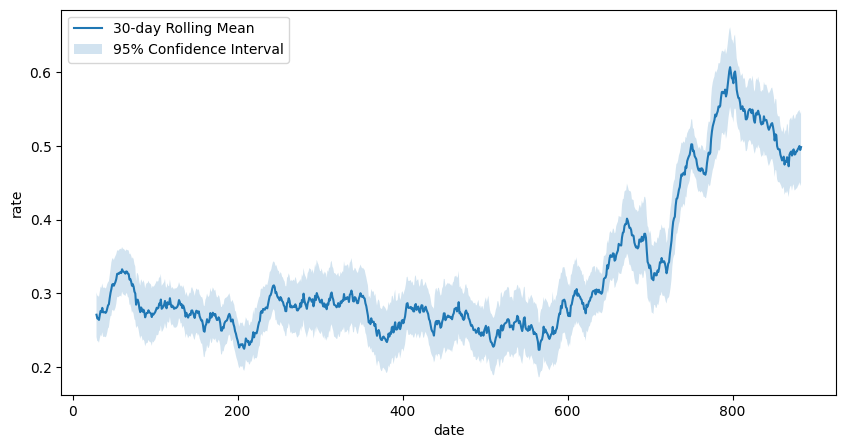

In [133]:
# 30 days rolling
#wsj_fpi = wsj_fpi.set_index('date')
#wsj_fpi['rate'].rolling(30).mean().plot(figsize=(10,5))

# calculate 95% confident intervals
window=30
z=1.96

rolling_mean=wsj_fpi['rate'].rolling(window).mean() # want to search by the date (start and end date)
rolling_std=wsj_fpi['rate'].rolling(window).std() 

upper=rolling_mean+z*(rolling_std/np.sqrt(window))
lower=rolling_mean-z*(rolling_std/np.sqrt(window))

# plot the visual
plt.figure(figsize=(10, 5))
plt.plot(rolling_mean, label='30-day Rolling Mean')
plt.fill_between(
    rolling_mean.index,
    lower,
    upper,
    alpha=0.2,
    label='95% Confidence Interval'
)

plt.xlabel('date')
plt.ylabel('rate')
plt.legend()
plt.show()


In [134]:
print(wsj_fpi['fiscal_articles'].sum())
print(wsj_fpi['total_articles'].sum())
print(round((wsj_fpi['fiscal_articles'].sum() / wsj_fpi['total_articles'].sum()) * 100, 2),'%', 
      "of articles are fiscal articles")

5411
16647
32.5 % of articles are fiscal articles


In [135]:
wsj_fpi.columns

Index(['date', 'total_articles', 'fiscal_articles', 'tariff_fiscal_articles',
       'non_tariff_fiscal_articles', 'rate', 'tariff_rate', 'non_tariff_rate',
       'fiscal_policy_index', 'tariff_fiscal_index',
       'non_tariff_fiscal_index'],
      dtype='object')

<Axes: title={'center': 'Fiscal Policy Index Over Time'}, xlabel='date'>

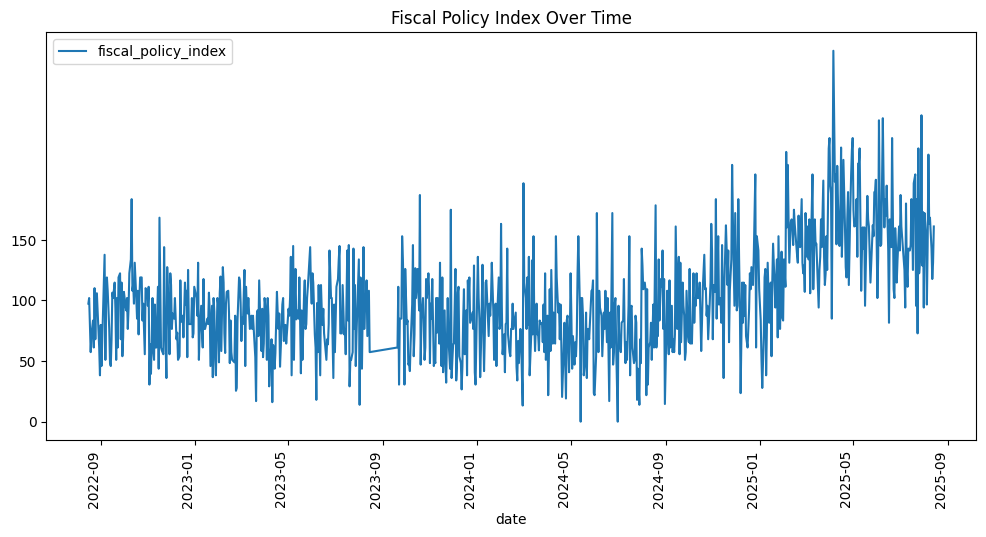

In [136]:
# daily fiscal policy index
#wsj_fpi = wsj_fpi.set_index('date')
wsj_fpi.plot(x="date", y="fiscal_policy_index", kind="line", 
    figsize=(12,6), rot=90, yticks=range(0, 200, 50), 
    title="Fiscal Policy Index Over Time")

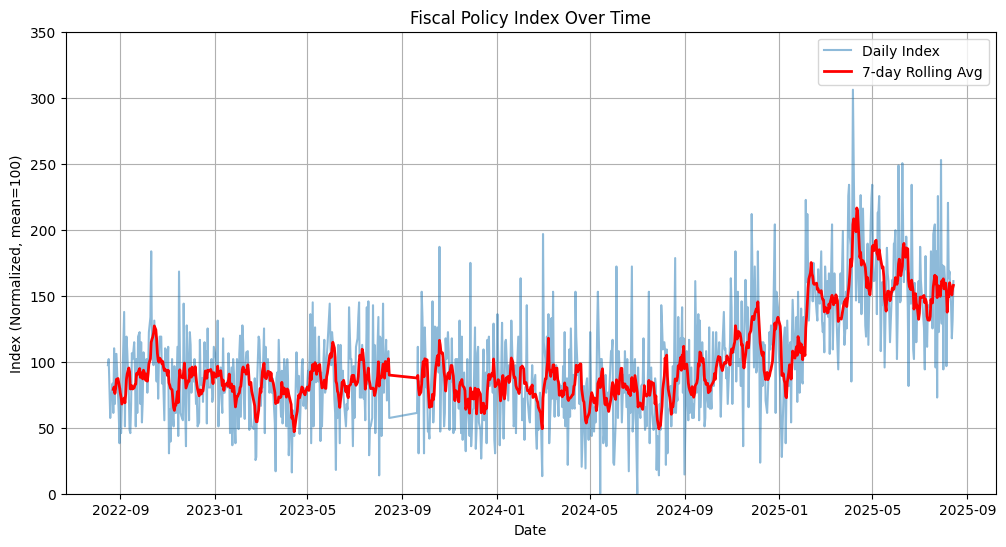

In [137]:
# with a 7 day rolling average (smoother)
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(wsj_fpi["date"], wsj_fpi["fiscal_policy_index"], label="Daily Index", alpha=0.5)
plt.plot(wsj_fpi["date"], wsj_fpi["fiscal_policy_index"].rolling(7).mean(), 
         label="7-day Rolling Avg", linewidth=2, color="red")

plt.title("Fiscal Policy Index Over Time")
plt.xlabel("Date")
plt.ylabel("Index (Normalized, mean=100)")
plt.ylim(0, 350)
plt.legend()
plt.grid(True)
plt.show()


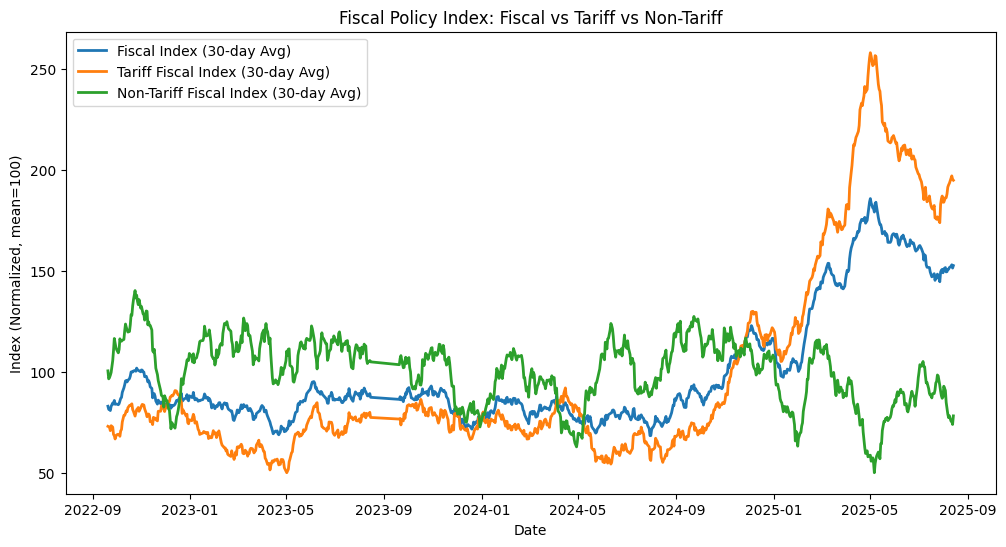

In [138]:

import pandas as pd
import matplotlib.pyplot as plt

# Plot with 7-day rolling average 
plt.figure(figsize=(12,6))

plt.plot(
    wsj_fpi["date"], wsj_fpi["fiscal_policy_index"].rolling(30).mean(),
    label="Fiscal Index (30-day Avg)", linewidth=2
)
plt.plot(
    wsj_fpi["date"], wsj_fpi["tariff_fiscal_index"].rolling(30).mean(),
    label="Tariff Fiscal Index (30-day Avg)", linewidth=2
)
plt.plot(
    wsj_fpi["date"], wsj_fpi["non_tariff_fiscal_index"].rolling(30).mean(),
    label="Non-Tariff Fiscal Index (30-day Avg)", linewidth=2
)

plt.title("Fiscal Policy Index: Fiscal vs Tariff vs Non-Tariff")
plt.xlabel("Date")
plt.ylabel("Index (Normalized, mean=100)")
plt.legend()
plt.show()

# calculate 95% confident intervals
window=30
z=1.96

rolling_mean=wsj_fpi['rate'].rolling(window).mean()
rolling_std=wsj_fpi['rate'].rolling(window).std()

upper=rolling_mean+z*(rolling_std/np.sqrt(window))
lower=rolling_mean-z*(rolling_std/np.sqrt(window))

# plot the visual
plt.figure(figsize=(10, 5))
plt.plot(rolling_mean, label='30-day Rolling Mean')
plt.fill_between(
    rolling_mean.index,
    lower,
    upper,
    alpha=0.2,
    label='95% Confidence Interval'
)

plt.xlabel('date')
plt.ylabel('rate')
plt.legend()
plt.show()


# NOTES ALL WE HAVE TO DO
- Add the date filter options to show the visualisation based on the date
- With the link: https://www.treasurydirect.gov/TA_WS/securities/jqsearch - can create a python file to select the security term and extract as an excel file. 

# Dashboard 
A. fiscal news: number of news, tarriff, non-tarriff news. The the index for 95% confidence intervals. 

B. Treasury Auction information: we can do visualisation based on security type, timeframe, security terms